<a href="https://colab.research.google.com/github/Shazaam91/Hate-Speech-Detection-/blob/main/Hate_Speech_Sinhala_BILSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
# Install necessary packages
!apt-get install fonts-noto
!pip install fasttext


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto is already the newest version (20201225-1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [96]:
# Download FastText model and clone FastText repository
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.vec.gz
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.bin.gz
!gzip -d cc.si.300.bin.gz
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText && sudo python setup.py install


--2024-09-05 07:13:09--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481477801 (459M) [binary/octet-stream]
Saving to: ‘cc.si.300.vec.gz’

cc.si.300.vec.gz    100%[===================>] 459.17M  35.1MB/s    in 12s     

2024-09-05 07:13:21 (38.2 MB/s) - ‘cc.si.300.vec.gz’ saved [481477801/481477801]

--2024-09-05 07:13:21--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3181346570 (3.0G) [application/octet-stream]
Saving to: ‘cc.si.

In [97]:
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.font_manager as fm
from collections import Counter
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, regularizers
import fasttext
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

nltk.download('punkt')
plt.rcParams['font.family'] = 'Noto Sans Sinhala'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
df = pd.read_csv('sinhala-hate-speech-dataset.csv', encoding='utf-8')

In [100]:
df.head(10)

,id,comment,label
0,1,`හුදෙකලා´ එකේ `ද´ ඇහෙනවද කාටහරි,0
1,2,18ක පෙනුමක් තියෙන්නේ,0
2,3,2020 එනවා කිව්නාට මෙහෙම එයි කියලා හිතුවේ නෑ පට්ට,0
3,4,25 කැල්ල..හම්මෝ..,0
4,5,25 කෙල්ල අයියලගෙ කාලද කොහෙද ඉන්නෙ,1
5,6,25 ක් වගේ ???ඉතින් වැලලියන්,1
6,7,25 ලුක් එක දැකල ඔලුව සවුත්තු උන තරිදු...,0
7,8,25ක පෙනුමක් කියපු කෑල්ලේ ඉදන් බලන එක නතර කලා,0
8,9,33ක් ගුවන්තොටුපළවල ලෝකයේ හිරවෙලා ඉන්නවා ඩුබායි...,0
9,10,5 දෙනා කිව්වෙ මේ පස්දෙනාද..,0


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6345 entries, 0 to 6344
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       6345 non-null   int64 
 1   comment  6345 non-null   object
 2   label    6345 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 148.8+ KB


In [102]:
df.describe()

,id,label
count,6345.000000,6345.000000
mean,3173.000000,0.544523
std,1831.788061,0.498053
min,1.000000,0.000000
25%,1587.000000,0.000000
50%,3173.000000,1.000000
75%,4759.000000,1.000000
max,6345.000000,1.000000


In [103]:
df.isnull().sum()

,0
id,0
comment,0
label,0


In [104]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    return text

# Apply cleaning function to all comments
df['cleaned_comment'] = df['comment'].apply(clean_text)

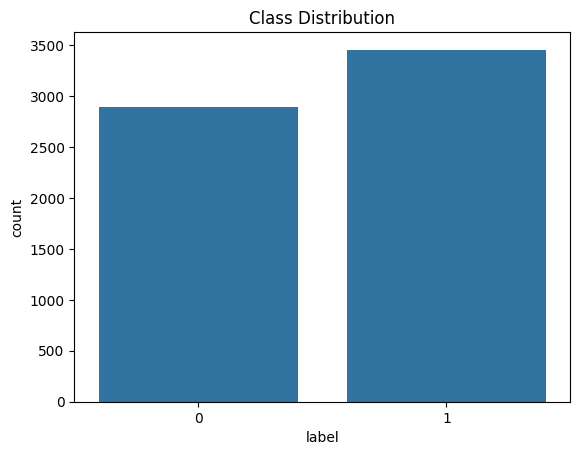

label
1    3455
0    2890
Name: count, dtype: int64


In [105]:
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

# Print the counts of each class
print(df['label'].value_counts())

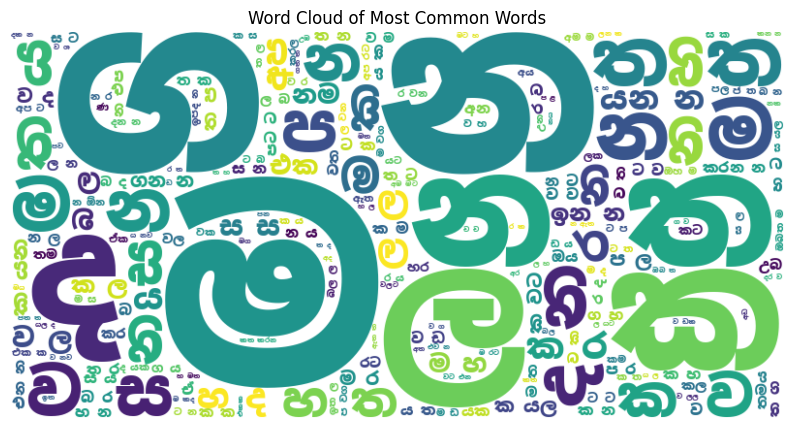

In [106]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='/content/NotoSansSinhala-Black.ttf').generate(' '.join(df['comment']))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words')
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


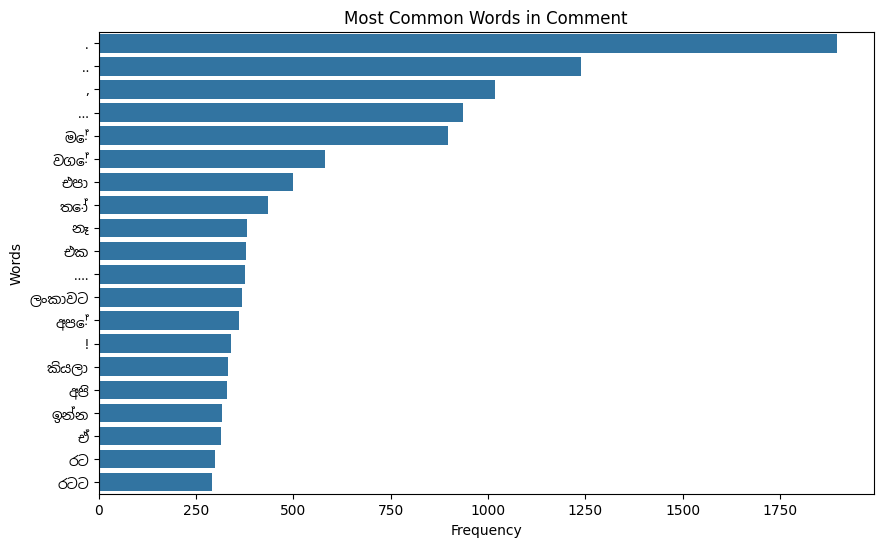

In [107]:
# Tokenize the posts
df['tokenized'] = df['comment'].apply(word_tokenize)

# Flatten the list of all words
all_words = [word for tokens in df['tokenized'] for word in tokens]

# Frequency distribution of the most common words
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

# Set the font properties for Sinhala text
sinhala_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/noto/NotoSansSinhala-Regular.ttf')

# Plotting the most common words
plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in common_words], y=[word[0] for word in common_words])
plt.title('Most Common Words in Comment')  # Title in English
plt.xlabel('Frequency')  # X-axis label in English
plt.ylabel('Words')  # Y-axis label in English
plt.xticks()  # X-ticks in default font (English)
plt.yticks(fontproperties=sinhala_prop, fontsize=10, rotation=0, ha='right')  # Y-ticks in Sinhala font, aligned to the right

plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


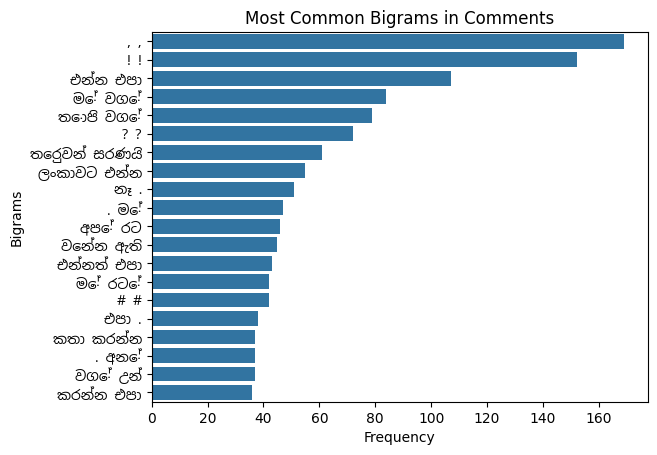

In [108]:
from nltk import ngrams

# Create bigrams
bigrams = list(ngrams(all_words, 2))
bigram_freq = Counter(bigrams).most_common(20)

# Set the font properties for Sinhala text
sinhala_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/noto/NotoSansSinhala-Regular.ttf')

# Plotting the most common bigrams
sns.barplot(x=[bigram[1] for bigram in bigram_freq], y=[' '.join(bigram[0]) for bigram in bigram_freq])

# Adding title and labels
plt.title('Most Common Bigrams in Comments')  # Title in English
plt.xlabel('Frequency')  # X-axis label in English
plt.ylabel('Bigrams')  # Y-axis label in English

# Adjust y-axis ticks for better visibility
plt.yticks(fontproperties=sinhala_prop, fontsize=10, ha='right', rotation=0)  # Y-ticks in Sinhala font, aligned to the right

plt.show()

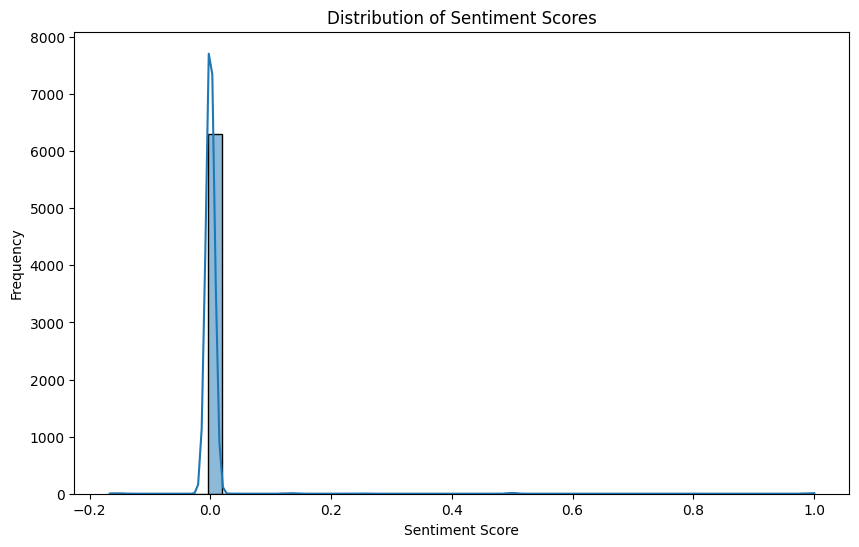

In [109]:
# Calculate sentiment polarity for each post
df['sentiment'] = df['comment'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plotting the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=50, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

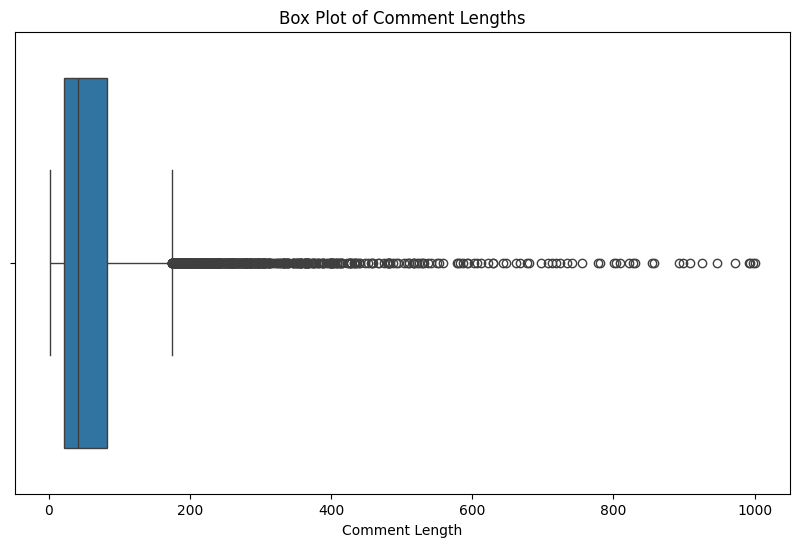

In [110]:
# Calculate the length of each comment
df['comment_length'] = df['comment'].apply(len)

# Plotting a box plot to detect outliers in comment lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['comment_length'])
plt.title('Box Plot of Comment Lengths')
plt.xlabel('Comment Length')
plt.show()

In [111]:
# Read dataset
dataset = []
with open('sinhala-hate-speech-dataset.csv', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        label = row['label']
        post = row['comment']
        item = [post]
        if label == '0':
            item.append(0)
        elif label == '1':
            item.append(1)
        else:
            print('ERROR: Unexpected label value')
            continue
        dataset.append(item)

# Extract posts and labels
posts, labels = zip(*dataset)
posts = list(posts)
labels = list(labels)

print(f"Number of records read: {len(dataset)}")
print(f"Length of posts: {len(posts)}")
print(f"Length of labels: {len(labels)}")

Number of records read: 6345
Length of posts: 6345
Length of labels: 6345


In [112]:
# Tokenize posts before resampling
tokenizer = Tokenizer()
tokenizer.fit_on_texts(posts)
sequences = tokenizer.texts_to_sequences(posts)
padded_sequences = pad_sequences(sequences, maxlen=120)

# Check lengths of padded_sequences and labels
print(f"Length of padded_sequences: {len(padded_sequences)}")
print(f"Length of labels: {len(labels)}")

Length of padded_sequences: 6345
Length of labels: 6345


In [113]:
# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
padded_sequences, labels = sm.fit_resample(padded_sequences, labels)

# Check class distribution after SMOTE
print(f"Length of padded_sequences after SMOTE: {len(padded_sequences)}")
print(f"Length of labels after SMOTE: {len(labels)}")

Length of padded_sequences after SMOTE: 6910
Length of labels after SMOTE: 6910


In [114]:
# Convert posts and labels to numpy arrays for consistency
posts = np.array(posts)
labels = np.array(labels)

In [115]:
# Trim the labels to match the length of posts
labels = labels[:len(posts)]

In [116]:
# Check the lengths after trimming
print(f"Length of posts after trimming: {len(posts)}")
print(f"Length of labels after trimming: {len(labels)}")

Length of posts after trimming: 6345
Length of labels after trimming: 6345


In [117]:
# split the text data into training and testing sets
X_train_text, X_test_text, y_train, y_test = train_test_split(posts, labels, test_size=0.1, random_state=42)

print(f"Training set size: {len(X_train_text)}, Test set size: {len(X_test_text)}")

Training set size: 5710, Test set size: 635


In [118]:
# Define parameters for tokenization and padding
vocab_size = 10000
max_length = 120
trunc_type = 'post'
oov_tok = ""

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Fit the tokenizer on the training text data
tokenizer.fit_on_texts(X_train_text)  # Ensure X_train_text is a list of texts

# Convert text data to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)  # Ensure X_test_text is a list of texts

# Pad sequences to ensure consistent input length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, truncating=trunc_type)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, truncating=trunc_type)

# Output shapes of the padded sequences
print(f"Shape of padded training data: {X_train_padded.shape}")
print(f"Shape of padded testing data: {X_test_padded.shape}")

Shape of padded training data: (5710, 120)
Shape of padded testing data: (635, 120)


In [119]:
# Load FastText model
ft = fasttext.load_model('cc.si.300.bin')

# Define the embedding dimension
embedding_dim = 300  # Ensure this matches the FastText vector size

# Initialize the embedding matrix
embeddings_matrix = np.zeros((vocab_size + 1, embedding_dim))

# Populate the embedding matrix
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:  # Skip words beyond vocab_size
        continue
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector


In [120]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    layers.Bidirectional(layers.LSTM(32, dropout=0.5)),
    layers.Dense(24, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       3,000,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,000,300 (11.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,300 (11.45 MB)

In [121]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [122]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [123]:
class_weights = {0: 1.5, 1: 2.0}  # Adjusting class weight

In [124]:
num_epochs = 100

# Fit the model with training data and include the callbacks for early stopping and checkpointing
history = model.fit(
    X_train_padded,  # Use the padded training data
    y_train,         # Use the training labels
    validation_split=0.1,  # Use 10% of the training data for validation
    epochs=num_epochs,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 43s 118ms/step - accuracy: 0.5906 - loss: 1.3195 - val_accuracy: 0.8284 - val_loss: 0.5227
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.8100 - loss: 0.8408 - val_accuracy: 0.8354 - val_loss: 0.4520
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - accuracy: 0.8184 - loss: 0.7575 - val_accuracy: 0.8476 - val_loss: 0.4355
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 38s 114ms/step - accuracy: 0.8213 - loss: 0.7182 - val_accuracy: 0.8476 - val_loss: 0.4204
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.8309 - loss: 0.7117 - val_accuracy: 0.8424 - val_loss: 0.4354
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.8371 - loss: 0.6706 - val_accuracy: 0.8616 - val_loss: 0.3921
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 37s 124ms/step - accuracy: 0.8345 - loss: 0.6749 - val_accuracy: 0.8476 - val_loss: 0.4008
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.8321 -

In [125]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy}")
print(f"Test Loss: {loss}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8564 - loss: 0.3516
Test Accuracy: 0.869291365146637
Test Loss: 0.33393511176109314


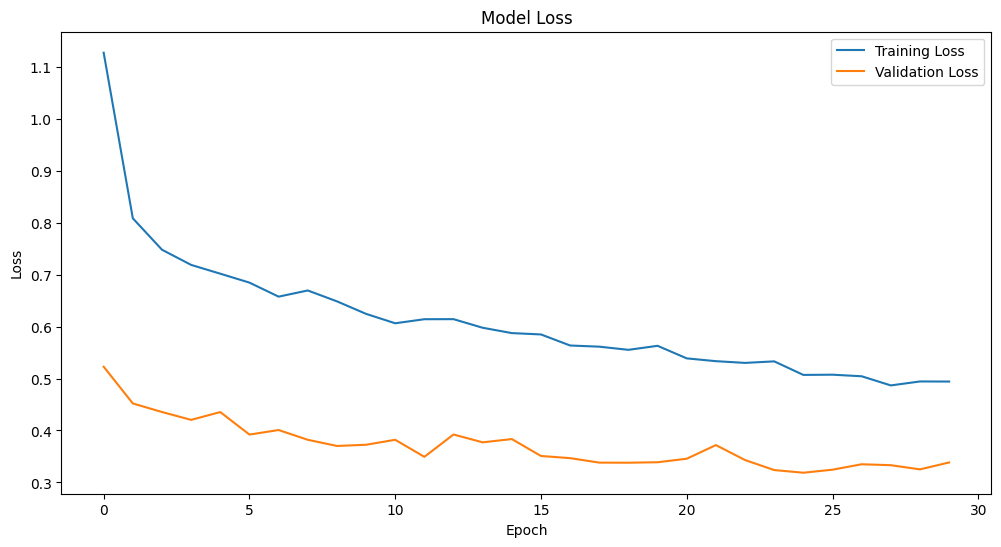

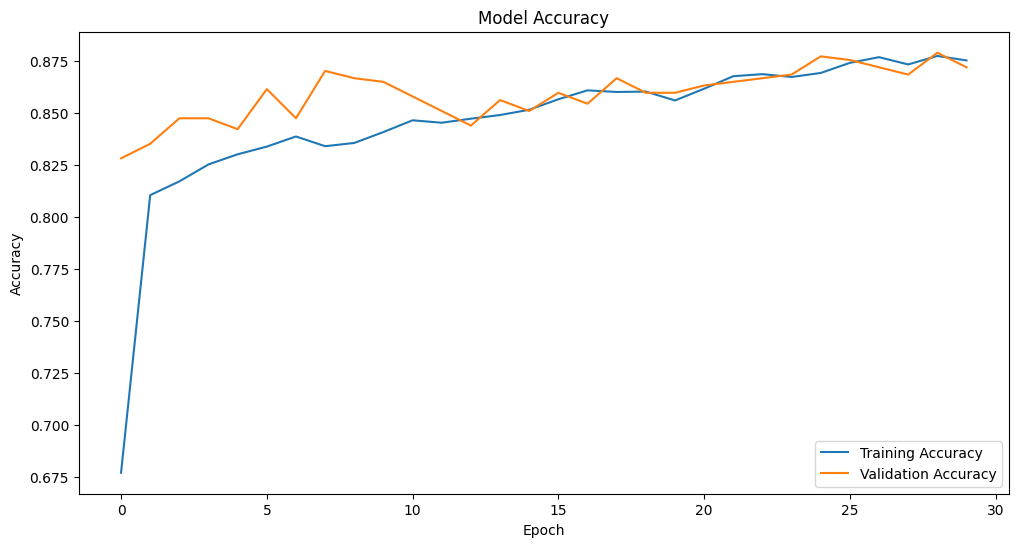

In [126]:
# Plotting training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [127]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, batch_size=32)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8564 - loss: 0.3516
Test Accuracy: 0.869291365146637
Test Loss: 0.33393511176109314


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       300
           1       0.89      0.86      0.87       335

    accuracy                           0.87       635
   macro avg       0.87      0.87      0.87       635
weighted avg       0.87      0.87      0.87       635

Confusion Matrix:
[[263  37]
 [ 46 289]]


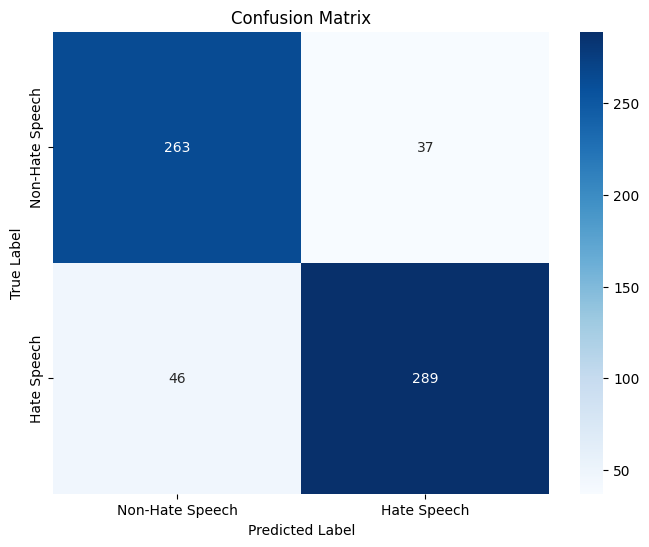

In [128]:
predictions = model.predict(X_test_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Hate Speech', 'Hate Speech'], yticklabels=['Non-Hate Speech', 'Hate Speech'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [152]:
# Saving the model Keras format
model.save('hate_speech_model.keras')

In [153]:
import pickle

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [154]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_hate_speech(texts, model, tokenizer, max_length, threshold=0.4):
    # Preprocess the input texts
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    # Make predictions
    predictions = model.predict(padded_sequences)

    # Determine the labels with threshold
    results = []
    for i, prediction in enumerate(predictions):
        label = 'Hate Speech' if prediction > threshold else 'Non-Hate Speech'
        confidence = float(prediction)
        results.append((texts[i], label, confidence))  # Store the original text, label, and confidence score

    return results

In [157]:
# Sample list of Sinhala texts
texts = [
    "මේ තියෙන්නෙ තෝ පිස්සු බඩුවක්",  # Example text 1
    "මන් ඊයේ මුස්ලිම් ඩෑල් එකක් එක්ක සෙල්ෆියක් ගත්තා සහජීවනේ රැකගෙන ඉදිරියට යන්න ඌ ඒක තාම දාලා නෑ...පරයා",  # Example text 2
    "මම සියලුම ඉස්ලාමීය රටවල් සම්පූර්ණයෙන්ම හෙළා දකිමි",  # Example text 3
    "අක්ක බැදල නැත්තන් අපි පෝලිමක් දාමු අක්කේ...",
    "අක්කට කාරයෙක් හොදටම හුකල වගෙ ඔය හුත්තිගෙ අම්මා ට හිකුවෙත් කාරයෙද්ද කොහෙද වගෙ",
    "මේ ගොං හම්බ පකයගෙ ඇගිල්ල යන විදිහ දැක්කද... සහරාන්ගෙ පැටවු තමයි මෙවුන්.... මරක්කල හැත්ත අහු උනොත් පකේ ඉදන් පතුරු ගහන්නෙ කැරි තම්බිය ",
    "මේ චිත්‍රපටය බලන්න.. මේ ඉස්ලාමීය අන්තවාදය පිලිබඳව ඉන්දීයානු චිත්‍රපටයක්.. මේ විත්‍රපටය පුරාවටම ඉස්ලාමීය අන්තවාදය, ජිහාඩය (අන්‍යාගමිකයන් මරා දමන) හා ඉස්ලාමීය කෘර ත්‍රස්තවාදය ගැන මනාවට පැහැදිලි වෙන චිත්‍රපටයක්.. මේ විත්‍රපටය පුරාවටම ඉස්ලාමීය අන්තවාදය මනාවට පැහැදිලි වේ..01 Video https://youtu.be/-4jOlMULkQ0මේ ඒ වගේම තවත් ඉස්ලාමීය ජිහඩ් (අන්‍යාගමිකයන් මරා දමන) අන්තවාදය ගැන කියවෙන චිත්‍රපටයක් 02 Video https://uc.xyz/27vbuT?pub=videoඒ සමගම මේ වීඩියෝ එකත් බලන්න. 03 Video https://youtu.be/hPYC8sU36SMමේ අමිත් වීරසිංහයන් විසින් කාලයකට කලින් ඉස්ලාමීය අන්තවාදය ගැන කල සම්මුඛ සාගච්ජාවක්.. මේ සාගච්ජාවට එරෙහිව එවකට ජලෙයිතු උලමා සංවිධානය අමිත් වීරසිංහට එරෙහිව කිරුලපන පොලිසියට කරන ලද පොලිස් පැමිණිල්ලක් නිසා අත්අඩංගුවට ගැනුනා.. පසුව කොළඹ CRP රක්ෂිත බන්ධනාගාරයේ රිමාන්ඩ් කෙරුවා. පසුව මාස තුනකට පසුව අමිත් වීරසිංහයන් නිදොස් කොට නිදොස් කලා.. මේ විත්‍රපටය බලලා අවසානයේ මේ සම්මුඛ සාගච්ජාවත් බලන්න..ජිහාඩය හා ඉස්ලාමීය අන්තවාදය ලංකාවේ කොතරම් දුරට ව්‍යාප්ත වී අැද්ද තේරුම් ගන්න මේක බලන්න..මිතුරන් අතරේ Share කර"
]

# Test the loaded model with multiple texts
results = predict_hate_speech(texts, loaded_model, tokenizer, max_length=50)

# Print the results
for result in results:
    text, label, confidence = result  # Ensure unpacking from each tuple correctly
    print(f"Text: {text}\nPrediction: {label} (Confidence: {confidence:.2f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Text: මේ තියෙන්නෙ තෝ පිස්සු බඩුවක්
Prediction: Hate Speech (Confidence: 0.98)

Text: මන් ඊයේ මුස්ලිම් ඩෑල් එකක් එක්ක සෙල්ෆියක් ගත්තා සහජීවනේ රැකගෙන ඉදිරියට යන්න ඌ ඒක තාම දාලා නෑ...පරයා
Prediction: Hate Speech (Confidence: 0.82)

Text: මම සියලුම ඉස්ලාමීය රටවල් සම්පූර්ණයෙන්ම හෙළා දකිමි
Prediction: Non-Hate Speech (Confidence: 0.26)

Text: අක්ක බැදල නැත්තන් අපි පෝලිමක් දාමු අක්කේ...
Prediction: Non-Hate Speech (Confidence: 0.15)

Text: අක්කට කාරයෙක් හොදටම හුකල වගෙ ඔය හුත්තිගෙ අම්මා ට හිකුවෙත් කාරයෙද්ද කොහෙද වගෙ
Prediction: Hate Speech (Confidence: 0.86)

Text: මේ ගොං හම්බ පකයගෙ ඇගිල්ල යන විදිහ දැක්කද... සහරාන්ගෙ පැටවු තමයි මෙවුන්.... මරක්කල හැත්ත අහු උනොත් පකේ ඉදන් පතුරු ගහන්නෙ කැරි තම්බිය 
Prediction: Hate Speech (Confidence: 0.99)

Text: මේ චිත්‍රපටය බලන්න.. මේ ඉස්ලාමීය අන්තවාදය පිලිබඳව ඉන්දීයානු චිත්‍රපටයක්.. මේ විත්‍රපටය පුරාවටම ඉස්ලාමීය අන්තවාදය, ජිහාඩය (අන්‍යාගමිකයන් මරා දමන) හා ඉස්ලාමීය කෘර ත්‍රස්තවාදය ගැන මනාවට පැහැදිලි වෙන චිත්‍රපටයක්.. මේ වි

<ipython-input-154-6798ed794054>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction)


In [134]:
from google.colab import files
files.download('tokenizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [135]:
from google.colab import files
files.download('hate_speech_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>